In [38]:
import pandas as pd 
import numpy as np
import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import rasterio
import os

In [39]:
# Load CSV file
data = pd.read_csv(r"D:\fourth year\gp\scratch\second_test500.csv")

# Read TIF files and extract features  
image_directory = r'D:\fourth year\gp\scratch\image_data'


In [40]:
# Normalize image data            
image_data = []
for file in data["imageFilename"]:
    image_path = os.path.join(image_directory, file)
    with rasterio.open(image_path) as src:
        image_data.append(src.read().squeeze())         
image_data = np.array(image_data)        
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Normalize numeric data        
numeric_data = data[["geometry_x", "geometry_y", "dx", "dy", "ratio"]].values      
scaler = MinMaxScaler()       
numeric_data = scaler.fit_transform(numeric_data)    

image_data = np.reshape(image_data, (image_data.shape[0], -1))
X = np.concatenate((image_data, numeric_data), axis=1)
X = scaler.fit_transform(X)

# Ensure there are no NaN or Inf values
X = np.nan_to_num(X, copy=False)

y = data[["speed", "direction"]].values

# Normalize y values
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)


C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ooooooo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [41]:
# Split data           
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# # Model architecture           
# model = Sequential()    
# model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.0005)))    
# model.add(Dropout(0.25)) 
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.0005)))    
# model.add(Dropout(0.25)) 
# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.0005)))    
# model.add(Dropout(0.25)) 
# model.add(Dense(2, activation='linear'))


#------------------------
# Define the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='linear'))

#---------------------

# Model architecture           
model = Sequential()    
model.add(Dense(256, activation='relu', input_dim=X.shape[1], kernel_initializer='glorot_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))    
model.add(Dropout(0.25)) 
...
model.add(Dense(2, activation='linear'))

# Compile model
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mean_absolute_error', optimizer=optimizer)    
early_stop = EarlyStopping(monitor='val_loss', patience=3)  


C:\Users\ooooooo\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
# Fit model  
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, callbacks=[early_stop])


Epoch 1/150
10/10 [==============================] - 3s 210ms/step - loss: 1.0632 - val_loss: 0.9670
Epoch 2/150
10/10 [==============================] - 2s 173ms/step - loss: 0.9177 - val_loss: 0.8329
Epoch 3/150
10/10 [==============================] - 1s 150ms/step - loss: 0.7949 - val_loss: 0.7228
Epoch 4/150
10/10 [==============================] - 2s 154ms/step - loss: 0.6950 - val_loss: 0.6342
Epoch 5/150
10/10 [==============================] - 2s 155ms/step - loss: 0.6129 - val_loss: 0.5625
Epoch 6/150
10/10 [==============================] - 2s 152ms/step - loss: 0.5459 - val_loss: 0.5026
Epoch 7/150
10/10 [==============================] - 2s 154ms/step - loss: 0.4906 - val_loss: 0.4505
Epoch 8/150
10/10 [==============================] - 2s 153ms/step - loss: 0.4408 - val_loss: 0.4038
Epoch 9/150
10/10 [==============================] - 1s 150ms/step - loss: 0.3952 - val_loss: 0.3614
Epoch 10/150
10/10 [==============================] - 1s 148ms/step - loss: 0.3548 - val_lo

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict wind speed and heading values for the test set
y_pred = model.predict(X_test)

# Compute the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the mean squared error and mean absolute error
print('Mean squared error:', mse)
print('Mean absolute error:', mae)

4/4 [==============================] - 0s 15ms/step
Mean squared error: 0.026219639761719985
Mean absolute error: 0.10446566589644221


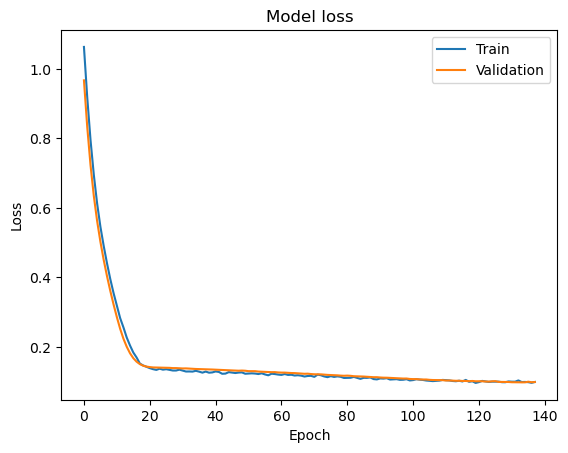

In [54]:
import matplotlib.pyplot as plt
# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [49]:
# Let's say y_pred are your model's predictions
y_pred = model.predict(X_test)

# Rescale back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Separate speed and direction for predicted and actual values
actual_speed = y_test_rescaled[:, 0]
predicted_speed = y_pred_rescaled[:, 0]
actual_direction = y_test_rescaled[:, 1]
predicted_direction = y_pred_rescaled[:, 1]

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual Speed": actual_speed,
    "Predicted Speed": predicted_speed,
    "Actual Direction": actual_direction,
    "Predicted Direction": predicted_direction
})

# Print the first 20 records
print(comparison_df.head(20))


4/4 [==============================] - 0s 17ms/step
    Actual Speed  Predicted Speed  Actual Direction  Predicted Direction
0           11.9        13.216284           -22.749           -22.927048
1           14.8        14.150218           -16.965           -17.467060
2           16.6        13.617429           -17.812           -18.212496
3           20.0        14.430713           -15.261           -15.697648
4            7.6        12.380317           -33.046           -30.791325
5           13.5        12.884650           -24.710           -24.506348
6           13.2        14.024980           -17.176           -17.805340
7           13.3        13.794734           -21.765           -22.086020
8           19.2        14.686121            -7.637            -8.512021
9           20.0        14.264377           -13.839           -14.429861
10          15.2        14.877443           -16.271           -16.993767
11          16.0        13.621348           -19.075           -19.513630

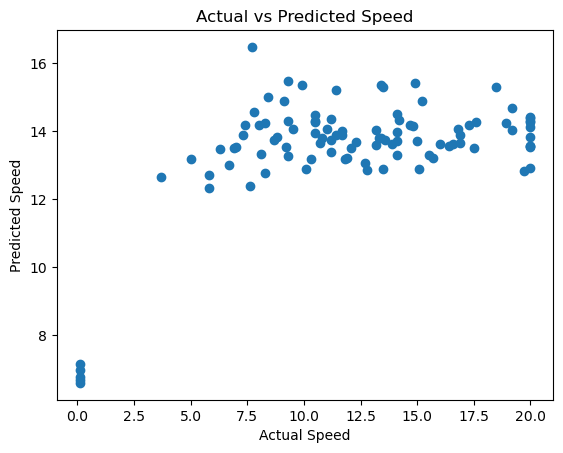

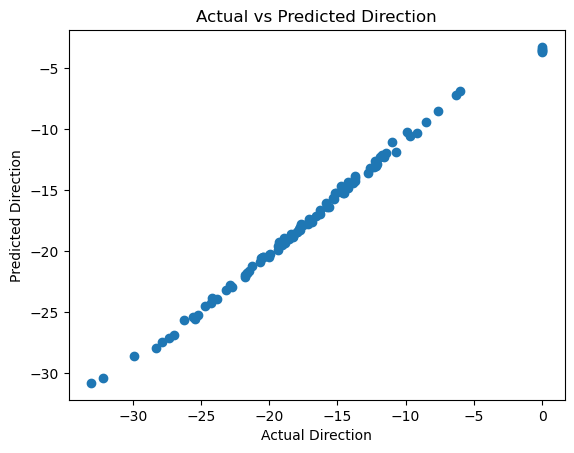

In [50]:
# Plot scatter plot for speed
plt.scatter(actual_speed, predicted_speed)
plt.title('Actual vs Predicted Speed')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.show()

# Plot scatter plot for direction
plt.scatter(actual_direction, predicted_direction)
plt.title('Actual vs Predicted Direction')
plt.xlabel('Actual Direction')
plt.ylabel('Predicted Direction')
plt.show()

In [51]:
# Save the model to a HDF5 file
model.save('wind_and_speed.h5')

In [52]:
import json

# Save model architecture to JSON
model_json = model.to_json()
with open("wind_and_speed.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to H5 file
model.save_weights("wind_and_speed_weights.h5")
